<a href="https://colab.research.google.com/github/marinba2200/Python-XML/blob/master/1223_RNN_for_Google's_stock_exercise.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Recurrent Neural Network

## Part 1 - Data Preprocessing

In [ ]:
# Importing the libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [ ]:
# Importing the training set (from 2012 to 2016)
dataset_train = pd.read_csv('Google_Stock_Price_Train.csv')
training_set = dataset_train.iloc[:, 1:2].values
print(training_set.shape)

(1258, 1)


In [ ]:
# Feature Scaling
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler(feature_range = (0, 1))
training_set_scaled = sc.fit_transform(training_set) #歸一化(0~1之間)

In [ ]:
# Creating a data structure with 60 timesteps and 1 output
# Should we change the number of timestep?
# Should we add other features from the data?
X_train = []
y_train = []
for i in range(60, 1258): #i=60 to 1257
    X_train.append(training_set_scaled[i-60:i, 0]) #之前是從0開始讀，這裡反過來從最新的開始每步60往回走
    y_train.append(training_set_scaled[i, 0])
X_train, y_train = np.array(X_train), np.array(y_train) #1198=1258-60

In [ ]:
print(X_train.shape)

(1198, 60)


In [ ]:
# Reshaping
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], -1))
print(X_train.shape)

(1198, 60, 1)


## Part 2 - Building the RNN

In [ ]:
# Importing the Keras libraries and packages
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dropout

In [ ]:
# Initialising the RNN
# Should we add the number of LSTM layer?
# Should we add the number of units in LSTM layer?
regressor = Sequential()

In [ ]:
# Adding the first LSTM layer and some Dropout regularisation
regressor.add(LSTM(units = 50, return_sequences = True, input_shape = (X_train.shape[1], 1))) # regressor.add(???(units = 50, return_sequences = True, input_shape = (X_train.shape[1], 1)))
#simplrRNN也可 #unit指的是空間上的，return_sequences是要不要迴(每個時間上的y-hat要不要提出[串起])
#如果input有9個(9個單字的句子),return_sequences=True就會有9個y-hat(會保留return)
regressor.add(Dropout(0.2))

In [ ]:
# Adding a second LSTM layer and some Dropout regularisation
regressor.add(LSTM(units = 50, return_sequences = True)) # regressor.add(???(units = 50, return_sequences = True))
regressor.add(Dropout(0.2))

In [ ]:
# Adding a third LSTM layer and some Dropout regularisation
regressor.add(LSTM(units = 50, return_sequences = True)) # regressor.add(???(units = 50, return_sequences = True))
regressor.add(Dropout(0.2))

In [ ]:
# Adding a fourth LSTM layer and some Dropout regularisation
regressor.add(LSTM(units = 50)) # regressor.add(???(units = 50))
#最後要接Dense了，return就不需要了
regressor.add(Dropout(0.2))

In [ ]:
# Adding the output layer
regressor.add(Dense(units = 1))

In [ ]:
# Compiling the RNN
regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')
regressor.summary()
#每個unit有4個index，共有50個unit，input的時間+空間(50+1)加上bias
##時間=unit數，空間=上一層(input)數
# ((50+1)+1)*4*50=10400, ((50+50)+1)*4*50=20200
#上一層的時間+空間(50+50)，再加上bias，此曾有50個unit,每個unit有4個index

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 60, 50)            10400     
_________________________________________________________________
dropout (Dropout)            (None, 60, 50)            0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 60, 50)            20200     
_________________________________________________________________
dropout_1 (Dropout)          (None, 60, 50)            0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 60, 50)            20200     
_________________________________________________________________
dropout_2 (Dropout)          (None, 60, 50)            0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 50)                2

In [ ]:
# Fitting the RNN to the Training set
regressor.fit(X_train, y_train, epochs = 200, batch_size = 32)

Epoch 1/200
38/38 [==============================] - 1s 15ms/step - loss: 0.0013
Epoch 2/200
38/38 [==============================] - 0s 13ms/step - loss: 0.0011
Epoch 3/200
38/38 [==============================] - 1s 13ms/step - loss: 0.0013
Epoch 4/200
38/38 [==============================] - 0s 13ms/step - loss: 0.0011
Epoch 5/200
38/38 [==============================] - 0s 13ms/step - loss: 0.0012
Epoch 6/200
38/38 [==============================] - 1s 13ms/step - loss: 0.0012
Epoch 7/200
38/38 [==============================] - 0s 13ms/step - loss: 0.0010
Epoch 8/200
38/38 [==============================] - 0s 13ms/step - loss: 0.0012
Epoch 9/200
38/38 [==============================] - 0s 13ms/step - loss: 0.0012
Epoch 10/200
38/38 [==============================] - 0s 13ms/step - loss: 0.0011
Epoch 11/200
38/38 [==============================] - 1s 13ms/step - loss: 0.0014
Epoch 12/200
38/38 [==============================] - 0s 13ms/step - loss: 0.0014
Epoch 13/200
38/38 [=====

## Part 3 - Making the predictions and visualizing the results

In [ ]:
# Getting the real stock price of 2017
dataset_test = pd.read_csv('Google_Stock_Price_Test.csv')
real_stock_price = dataset_test.iloc[:, 1:2].values

In [ ]:
# Getting the predicted stock price of 2017
dataset_total = pd.concat((dataset_train['Open'], dataset_test['Open']), axis = 0) #train跟test data串在一起(因為需要知道前一年是誰)
inputs = dataset_total[(len(dataset_total)-len(dataset_test)-60) : (len(dataset_total)-len(dataset_test))].values
#總共的長度(屁股)-test的長度(屁股)=train的長度(屁股) 取總資料集[訓練長度開頭(-60)~訓練長度(屁股)]的值
inputs = inputs.reshape(-1,1) #轉換成Nx1的資料
print(inputs.shape)

inputs = sc.transform(inputs) #sc是scale的function
X_test = inputs[0:60, 0] #抓test資料
predicted_stock_price = []
for i in range(0, 20):
    p = regressor.predict(X_test.reshape(1, -1, 1))
    predicted_stock_price.append(p)
    X_test = np.roll(X_test, -1) # X_test = np.roll(X_test, ???) 
    #排序test: (0~9)改成(1~9,0)=>新的(1~10)
    X_test[-1] = p # X_test[???] = p
    #最後一個0的值再用p(預測)取代掉=新的(0~9)

predicted_stock_price = np.reshape(predicted_stock_price, (-1, 1)) #先做預測
predicted_stock_price = sc.inverse_transform(predicted_stock_price) #再inverse預測

(60, 1)


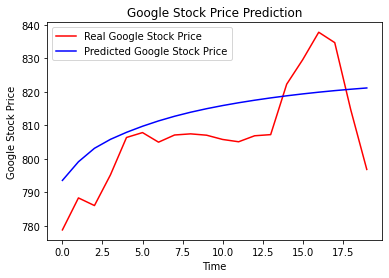

In [ ]:
# Visualising the results
plt.plot(real_stock_price, color = 'red', label = 'Real Google Stock Price')
plt.plot(predicted_stock_price, color = 'blue', label = 'Predicted Google Stock Price')
plt.title('Google Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Google Stock Price')
plt.legend()
plt.show()

### 錯的

In [ ]:
# Getting the predicted stock price of 2017
# Is it correct?
dataset_total = pd.concat((dataset_train['Open'], dataset_test['Open']), axis = 0) #train跟test data串在一起(因為需要知道前一年是誰)
inputs = dataset_total[len(dataset_total) - len(dataset_test) - 60:].values #總共的長度-test的長度=train的長度
inputs = inputs.reshape(-1,1)
inputs = sc.transform(inputs) #sc是scale的function(歸一化)
X_test = []
###############這段是錯的###############
for i in range(60, 80):
    X_test.append(inputs[i-60:i, 0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
########################################
predicted_stock_price = regressor.predict(X_test) #先做預測
predicted_stock_price = sc.inverse_transform(predicted_stock_price) #再inverse預測

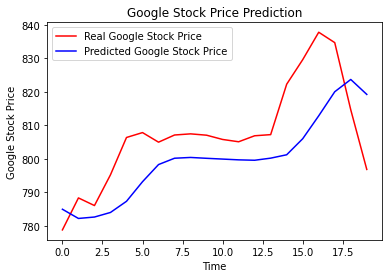

In [ ]:
# Visualising the results
plt.plot(real_stock_price, color = 'red', label = 'Real Google Stock Price')
plt.plot(predicted_stock_price, color = 'blue', label = 'Predicted Google Stock Price')
plt.title('Google Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Google Stock Price')
plt.legend()
plt.show()